# **Social Media Opinion on Trump Citizenship Policy**

## *1.1. Imports necessary libraries (always first)*

In [91]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import os



## *1.2. Load the dataset*

In [6]:
df = pd.read_excel("us_comments.xlsx")

In [7]:
df.head()

,Comment ID,Media Outlet,Time,Comment Text,Likes,Reply Count
0,C1,Forbes Breaking News,2026-01-26T06:10:45,Thank you President Trump! The American People...,0,0
1,C2,Forbes Breaking News,2026-01-24T15:39:52,I wonder if this includes people like Peter Th...,0,0
2,C3,Forbes Breaking News,2026-01-23T23:44:53,That's right President Trump,0,0
3,C4,Forbes Breaking News,2026-01-23T20:25:32,Please have the IRS take a look at their taxes...,0,0
4,C5,Forbes Breaking News,2026-01-23T18:50:00,"First off, why do we pay for childcare when th...",0,0


In [8]:
df.shape

(57384, 6)

In [9]:
df.columns

Index(['Comment ID', 'Media Outlet', 'Time', 'Comment Text', 'Likes',
       'Reply Count'],
      dtype='object')

## *1.3. Rename columns (very important)*

Spaces in column names cause pain later. Fix them now.

In [10]:
df = df.rename(columns={
    'Comment ID': 'comment_id',
    'Media Outlet': 'media_outlet',
    'Time': 'time',
    'Comment Text': 'comment_text',
    'Likes': 'likes',
    'Reply Count': 'reply_count'
})


Check again

In [11]:
df.columns

Index(['comment_id', 'media_outlet', 'time', 'comment_text', 'likes',
       'reply_count'],
      dtype='object')

## *1.4. Basic sanity checks*

In [12]:
df.isnull().sum()

comment_id      0
media_outlet    0
time            0
comment_text    1
likes           0
reply_count     0
dtype: int64

We can see that there is one row with no comment, so I need to remove that row.

In [13]:
df = df.dropna(subset=['comment_text', 'time'])

Check text length

In [14]:
df['comment_text'].str.len().describe()

count    57377.000000
mean       160.415027
std        269.427376
min          1.000000
25%         45.000000
50%         91.000000
75%        179.000000
max       9246.000000
Name: comment_text, dtype: float64

#### **Count — 57,377**
This is the number of comments in your dataset.

#### **mean — 160.4**
The average comment length is about 160 characters.

#### **std — 269.4**
This is the spread / variability of comment lengths.

#### **min — 1**
The shortest comment is 1 character.

#### **25% — 45**
25% of all comments are 45 characters or shorter.

#### **50% (median) — 91**
Half of all comments are 91 characters or shorter.

#### **75% — 179**
75% of comments are 179 characters or shorter.

#### **max — 9246**
The longest comment has 9,246 characters

### visualize it

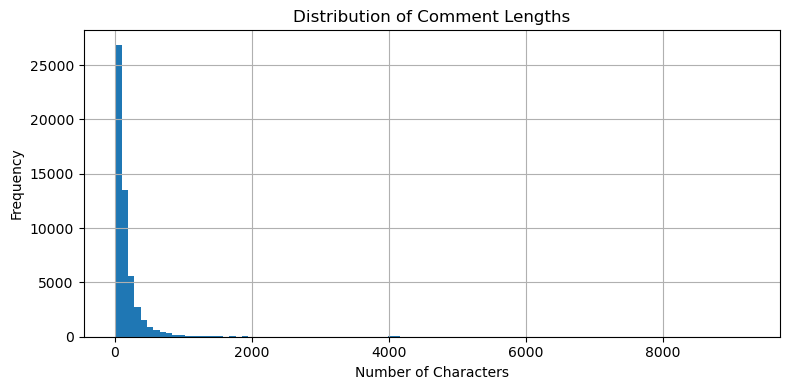

In [88]:
df['comment_text'].str.len().hist(bins=100, figsize=(8,4))
plt.title("Distribution of Comment Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

✅ The median is much lower than the mean

✅ That tells us the distribution is right-skewed

✅ A few very long comments pull the average up.

## *1.5. Convert time to datetime (critical)*

In [15]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')

Drop invalid timestamps

In [16]:
df = df.dropna(subset=['time'])

Confirm

In [17]:
df['time'].head()

0   2026-01-26 06:10:45
1   2026-01-24 15:39:52
2   2026-01-23 23:44:53
3   2026-01-23 20:25:32
4   2026-01-23 18:50:00
Name: time, dtype: datetime64[ns]

## *1.6. Create time features*

✅ Keep time

✅ Add month column

In [18]:
df['year_month'] = df['time'].dt.to_period('M').astype(str)
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month


#### Check distribution

In [19]:
df['year_month'].value_counts().sort_index()


year_month
2024-11      787
2024-12     8476
2025-01     4816
2025-02     1560
2025-03     2281
2025-04     1256
2025-05      460
2025-06     4099
2025-07     4530
2025-08      119
2025-09     4193
2025-10      637
2025-11     1457
2025-12    18594
2026-01     4118
Name: count, dtype: int64

We can see uneven months. Which is fine, as it is the characterstics of the social media comments.

## *1.7. Comment volume per month (first analysis)*

In [20]:
monthly_volume = df.groupby('year_month').size()
monthly_volume

year_month
2024-11      787
2024-12     8476
2025-01     4816
2025-02     1560
2025-03     2281
2025-04     1256
2025-05      460
2025-06     4099
2025-07     4530
2025-08      119
2025-09     4193
2025-10      637
2025-11     1457
2025-12    18594
2026-01     4118
dtype: int64

| Month   | Meaning                     |
| ------- | --------------------------- |
| 2024-11 | Low activity (early period) |
| 2024-12 | Big spike (8,476 comments)  |
| 2025-01 | High sustained discussion   |
| 2025-02 | Drop in engagement          |
| 2025-03 | Moderate recovery           |
| 2025-04 | Declining interest          |
| 2025-05 | Very low attention          |
| 2025-06 | Strong resurgence           |
| 2025-07 | Continued high interest     |
| 2025-08 | Near silence                |
| 2025-09 | Major spike                 |
| 2025-10 | Drop again                  |
| 2025-11 | Moderate activity           |
| 2025-12 | **Huge peak (18,594)**      |
| 2026-01 | High but declining          |

### Plot

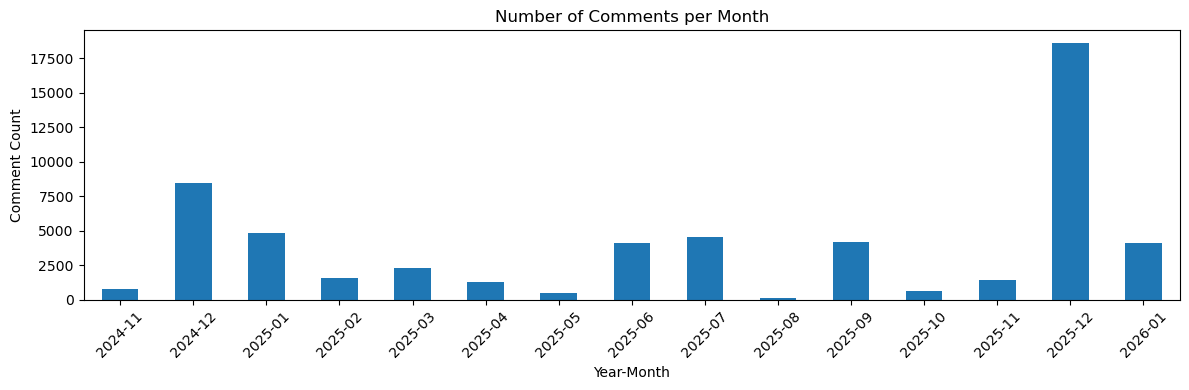

In [21]:
plt.figure(figsize=(12,4))
monthly_volume.plot(kind='bar')
plt.title("Number of Comments per Month")
plt.xlabel("Year-Month")
plt.ylabel("Comment Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## *1.8. Text cleaning*

### This is important part of the process
✅ Lowercasing

✅ Remove URLs

✅ Remove mentions from replays

✅ Remove hashtags

✅ Keep letters only

✅ Replaces every stretch of whitespace with a single space

Prepare a function called **clean_text** for this stage.

In [22]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)      # remove URLs
    text = re.sub(r"@\w+", "", text)         # remove mentions
    text = re.sub(r"#\w+", "", text)         # remove hashtags
    text = re.sub(r"[^a-z\s]", "", text)     # keep letters only
    text = re.sub(r"\s+", " ", text).strip()
    return text

Apply it

In [23]:
df['clean_comment'] = df['comment_text'].astype(str).apply(clean_text)

## *1.9. Remove very short comments*

In [24]:
df = df[df['clean_comment'].str.split().str.len() >= 3]

In [25]:
df

,comment_id,media_outlet,time,comment_text,likes,reply_count,year_month,year,month,clean_comment
0,C1,Forbes Breaking News,2026-01-26 06:10:45,Thank you President Trump! The American People...,0,0,2026-01,2026,1,thank you president trump the american people you
1,C2,Forbes Breaking News,2026-01-24 15:39:52,I wonder if this includes people like Peter Th...,0,0,2026-01,2026,1,i wonder if this includes people like peter th...
2,C3,Forbes Breaking News,2026-01-23 23:44:53,That's right President Trump,0,0,2026-01,2026,1,thats right president trump
3,C4,Forbes Breaking News,2026-01-23 20:25:32,Please have the IRS take a look at their taxes...,0,0,2026-01,2026,1,please have the irs take a look at their taxes...
4,C5,Forbes Breaking News,2026-01-23 18:50:00,"First off, why do we pay for childcare when th...",0,0,2026-01,2026,1,first off why do we pay for childcare when the...
...,...,...,...,...,...,...,...,...,...,...
57379,C57380,Democracy Now,2026-01-17 17:09:43,@AmyRobillard-q8w as a Jamaican I can affirm t...,0,0,2026-01,2026,1,qw as a jamaican i can affirm the rest of the ...
57380,C57381,Democracy Now,2026-01-18 04:23:32,@AmyRobillard-q8wmy daughter said the SAME thi...,0,0,2026-01,2026,1,qwmy daughter said the same thing to me i told...
57381,C57382,Democracy Now,2026-01-18 04:26:45,@joanemanuel4719I’m sure tourism is dead in Am...,0,0,2026-01,2026,1,m sure tourism is dead in america thanks to trump
57382,C57383,Democracy Now,2026-01-22 20:30:48,​@jeanandre6129You ppl blame black Americans f...,0,0,2026-01,2026,1,ppl blame black americans for everything and e...


## *1.10. Engagement sanity check (likes & replies)*

In [26]:
df[['likes', 'reply_count']].describe()

,likes,reply_count
count,53486.000000,53486.000000
mean,5.075272,0.534925
std,81.747867,5.728190
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,7274.000000,390.000000


### 1️⃣ Count — 53,486
We can see 53,486 comments with a likes/replies record.
### 2️⃣ Mean — 5.07 likes, 0.53 replies
Average likes per comment: 5
Average replies per comment: 0.53
Interpretation:
Most comments get very few interactions
Only a small fraction are engaging enough to get replies
### 3️⃣ Std — 81.75 likes, 5.73 replies
This is the spread / variation

Likes are highly skewed: some comments are extremely popular, most get almost none

Replies also vary but less extremely

### 4️⃣ Min — 0 likes/replies

Many comments get no engagement (totally normal)

25th percentile = 0, 50th percentile (median) = 0 → confirms most comments are “ignored”

### 5️⃣ 25%, 50%, 75% — quartiles

Likes: 25% = 0, median = 0, 75% = 1

Most comments have ≤1 like

Replies: 25%, 50%, 75% = 0

Most comments don’t get a reply

✅ This confirms long-tail engagement: a few comments dominate interaction.

### 6️⃣ Max — 7274 likes, 390 replies

A few comments went viral

  ✅ Huge spikes in attention

  ✅ These will dominate averages if we’re not careful

This explains why mean >> median

In [27]:
df.groupby('year_month')[['likes', 'reply_count']].mean()

,likes,reply_count
year_month,,
2024-11,4.553696,0.741980
2024-12,4.562468,0.495058
2025-01,6.158927,0.560279
2025-02,0.897712,0.129206
2025-03,27.373581,0.706310
2025-04,1.951817,0.256128
2025-05,5.401330,1.093126
2025-06,5.260016,0.672663
2025-07,4.297605,0.436092


#### VISUALIZATION

C:\Users\Hp\AppData\Local\Temp\ipykernel_9220\3436709588.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_grouped.index = pd.to_datetime(df_grouped.index)


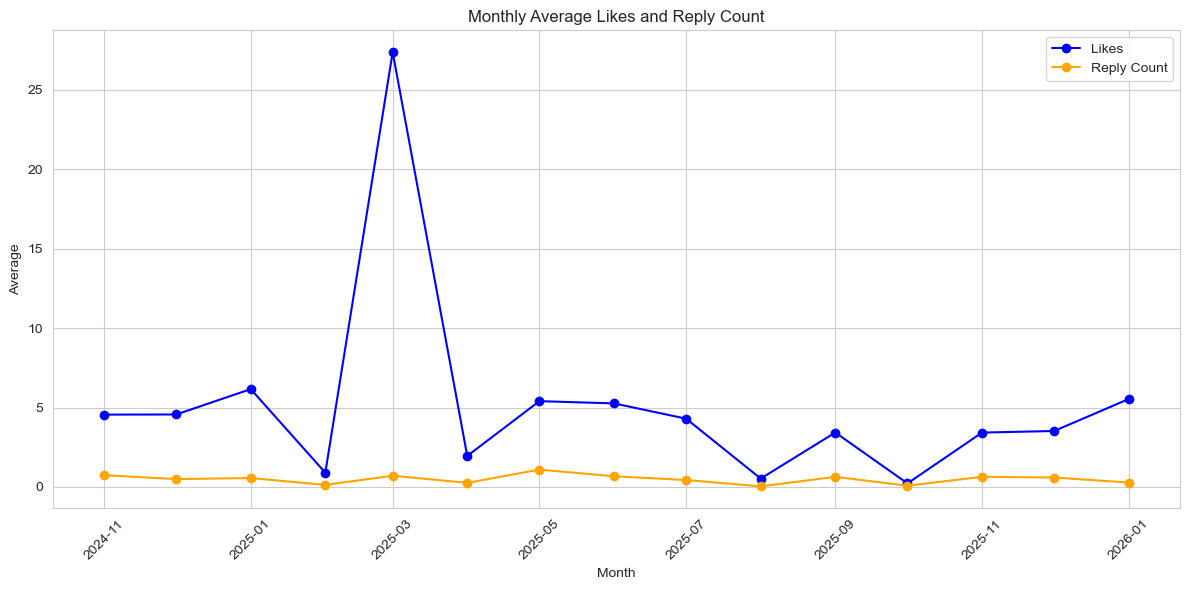

In [93]:
df_grouped = df.groupby('year_month')[['likes', 'reply_count']].mean()

# Convert the index to datetime for proper plotting
df_grouped.index = pd.to_datetime(df_grouped.index)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot likes
plt.plot(df_grouped.index, df_grouped['likes'], marker='o', label='Likes', color='blue')

# Plot reply_count
plt.plot(df_grouped.index, df_grouped['reply_count'], marker='o', label='Reply Count', color='orange')

plt.title('Monthly Average Likes and Reply Count')
plt.xlabel('Month')
plt.ylabel('Average')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### A few observations:

✅ Spikes: March 2025 has a huge jump in likes (27.37) compared to other months. That’s clearly an outlier.

✅ Low activity months: February 2025, August 2025, and October 2025 are really low for both likes and reply_count.

✅ Trends: There seems to be some variability month-to-month without a clear steady upward or downward trend, but a few months like January 2025 and May 2025 show moderate engagement.

### Generates 10 comments with max reactions and replays

In [97]:
# Combine likes and reply_count to rank top comments
df['total_engagement'] = df['likes'] + df['reply_count']

# Get top 10 comments by total engagement
top_comments = df.nlargest(10, 'total_engagement')

# Display only relevant columns (adjust if your comment text column has a different name)
top_comments_display = top_comments[['comment_text', 'likes', 'reply_count', 'total_engagement']]
print(top_comments_display)

                                            comment_text  likes  reply_count  \
10903  Remember when Trump said Obama should be impea...   7274           85   
8628                    We have Schoolhouse Rock at home   7261           26   
11357                   We have Schoolhouse Rock at home   7261           26   
11442  But Mr. Executive Order...I just don't underst...   6604           24   
11325  He really hit the move kids do. "It's cheating...   4678           17   
7815   The fact that these clowns made the argument t...   4075          226   
48027  My Mother and father came migrated to America,...   3385          333   
11018  A lot of people aren’t getting the reason why ...   3277          172   
55818  Trump is a beneficiary of birthright citizensh...   3039          390   
56215  So the whole "they should come in the right wa...   2443          270   

       total_engagement  
10903              7359  
8628               7287  
11357              7287  
11442          

### WE CAN SEE THE TOP 10 COMMENTS.

## **2. Sentiment analysis**

## *2.1. Start with VADER (standard for social media).*

In [28]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Define sentiment function

In [29]:
def get_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'


### Apply it on the comments

In [30]:
df['sentiment'] = df['clean_comment'].apply(get_sentiment)

### Check distribution

In [31]:
df['sentiment'].value_counts(normalize=True)

sentiment
negative    0.373444
positive    0.351662
neutral     0.274894
Name: proportion, dtype: float64

C:\Users\Hp\AppData\Local\Temp\ipykernel_9220\2660330333.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_dist.index, y=sentiment_dist.values, palette='viridis')


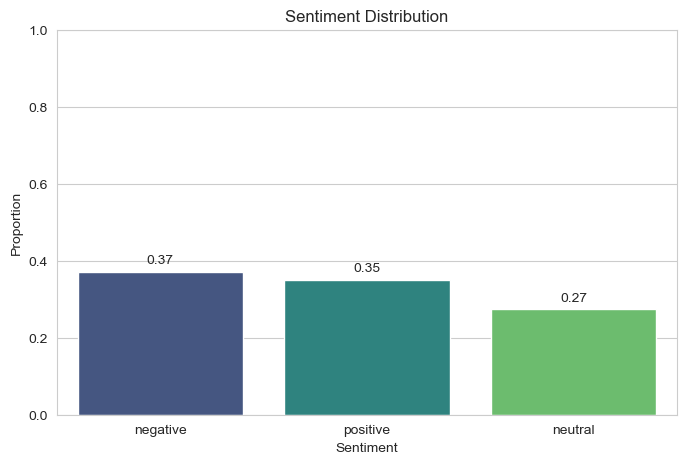

In [94]:
# Compute normalized value counts
sentiment_dist = df['sentiment'].value_counts(normalize=True)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=sentiment_dist.index, y=sentiment_dist.values, palette='viridis')

plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.ylim(0, 1)  # Since normalized
for i, v in enumerate(sentiment_dist.values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')  # add

## *2.2. Monthly sentiment aggregation (very important)*

In [32]:
monthly_sentiment = (
    df.groupby(['year_month', 'sentiment'])
      .size()
      .unstack(fill_value=0)
)

monthly_sentiment_prop = monthly_sentiment.div(
    monthly_sentiment.sum(axis=1), axis=0
)

Plot

<Figure size 4000x2000 with 0 Axes>

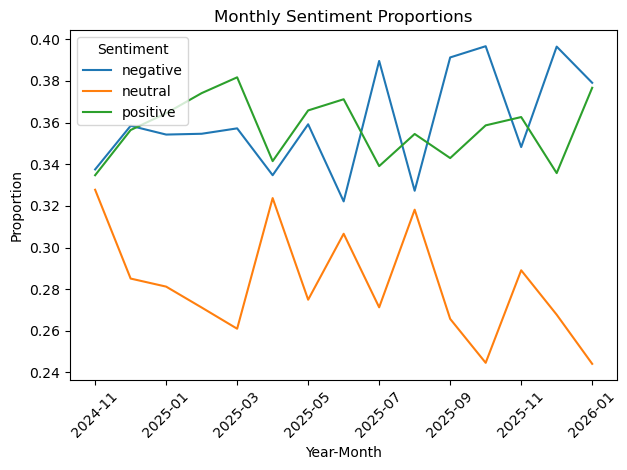

In [33]:
plt.figure(figsize=(40,20))
monthly_sentiment_prop.plot()
plt.title("Monthly Sentiment Proportions")
plt.xlabel("Year-Month")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

#### This is one of main results figures

## *2.3. Handle months with low or zero data (properly)*

In [34]:
monthly_counts = df.groupby('year_month').size()

low_data_months = monthly_counts[monthly_counts < 30]
low_data_months


Series([], dtype: int64)

📌 These months:

Stay in volume analysis

Are not over-interpreted in sentiment discussion

## **3. Topic Modeling with LDA**

## *3.1. Import necessary libraries*

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

## *3.2. Vectorize your comments*

##### Use CountVectorizer for LDA. Set reasonable min/max thresholds to reduce noise.

In [36]:
vectorizer = CountVectorizer(
    max_df=0.9,       # ignore very common words
    min_df=10,        # ignore rare words
    stop_words='english'
)

X = vectorizer.fit_transform(df['clean_comment'])

Check shape

In [37]:
X.shape

(53486, 5904)

## *3.3. Fit LDA*

Decide number of topics. Start with 6–8 topics for clarity.

In [38]:
lda = LatentDirichletAllocation(
    n_components=6,
    random_state=42
)

lda.fit(X)


,n_components,6
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


## *3.4. Display top words per topic*

In [39]:
words = vectorizer.get_feature_names_out()

for i, topic in enumerate(lda.components_):
    top_words = [words[j] for j in topic.argsort()[-10:]]
    print(f"Topic {i+1}: {', '.join(top_words)}")


Topic 1: going, man, thank, america, just, hes, people, like, president, trump
Topic 2: citizenship, visa, american, people, citizens, immigrants, illegal, born, citizen, trump
Topic 3: want, american, like, usa, just, dont, americans, america, country, people
Topic 4: babies, baby, countries, child, country, id, birthright, citizen, birth, citizenship
Topic 5: children, subject, jurisdiction, citizens, citizenship, born, united, th, amendment, states
Topic 6: like, doesnt, right, change, vote, people, court, just, dont, constitution


#### Topic 1: Political Figures & Public Opinion

#### Topic 2: Immigration & Citizenship Law

#### Topic 3: National Identity & Patriotism

#### Topic 4: Birthright & Citizenship of Children

#### Topic 5: Legal Framework of Citizenship

#### Topic 6: Voting Rights & Constitutional Debate

## *3.5. Assign dominant topic to each comment*

In [40]:
topic_values = lda.transform(X)
df['dominant_topic'] = topic_values.argmax(axis=1)

#### Now each comment has a dominant topic ID. We can analyze sentiment per topic next.

In [102]:
# Step 1: Map topic numbers to meaningful names
topic_names = {
    0: "Political Figures & Public Opinion",
    1: "Immigration & Citizenship Law",
    2: "National Identity & Patriotism",
    3: "Birthright & Citizenship of Children",
    4: "Legal Framework of Citizenship",
    5: "Voting Rights & Constitutional Debate"
}

# Step 2: Add a new column with the topic name
df['dominant_topic_name'] = df['dominant_topic'].map(topic_names)

# Step 3: Inspect the first few rows
df[['comment_text', 'dominant_topic', 'dominant_topic_name']].head(20)

# Step 4: Save
# Save the DataFrame to Excel
df.to_excel("comments_with_topics.xlsx", index=False)

## *3.6. Topic distribution per month*

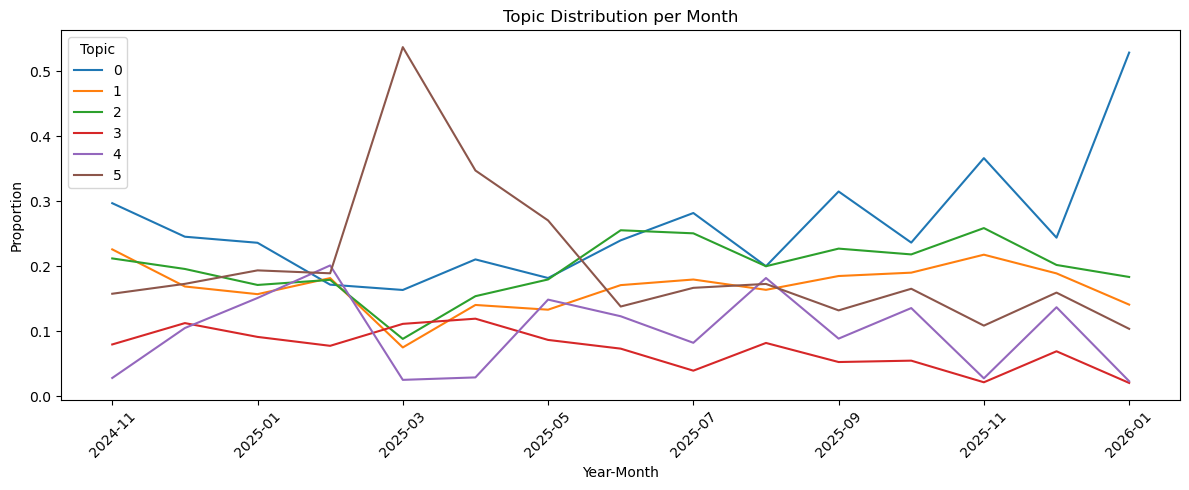

In [41]:
monthly_topic = df.groupby(['year_month', 'dominant_topic']).size().unstack(fill_value=0)
monthly_topic_prop = monthly_topic.div(monthly_topic.sum(axis=1), axis=0)

monthly_topic_prop.plot(figsize=(12,5))
plt.title("Topic Distribution per Month")
plt.xlabel("Year-Month")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="Topic")
plt.tight_layout()
plt.show()

#### This helps ud to see which topic dominates when, even with uneven months.

## **4. Emotion or polarization analysis**

## *4.1. Install and import emotion tools*

#### I’ll use NRCLex (NRC Emotion Lexicon) for emotion analysis, and textblob for polarity check.

In [42]:
from nrclex import NRCLex
from textblob import TextBlob

## *4.2. Install Hugging Face pipeline*

In [45]:
from transformers import pipeline

## *4.3. Emotion classifier*

We’ll use a political-safe emotion model

In [46]:
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True
)


config.json: 0.00B [00:00, ?B/s]

C:\Users\Hp\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Hp\.cache\huggingface\hub\models--j-hartmann--emotion-english-distilroberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: j-hartmann/emotion-english-distilroberta-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Apply emotion analysis (safe version)

## *4.4. Apply emotion analysis*

#### Models have token limits, so we truncate text.

In [48]:
def get_emotion_scores(text):
    if not isinstance(text, str) or text.strip() == "":
        return {}
    
    output = emotion_classifier(text[:512])

    # Case 1: pipeline returns list of lists (return_all_scores=True)
    if isinstance(output[0], list):
        results = output[0]
        return {r['label']: r['score'] for r in results}

    # Case 2: pipeline returns single label
    elif isinstance(output[0], dict):
        return {output[0]['label']: output[0]['score']}

    else:
        return {}


In [49]:
emotion_df = df['clean_comment'].apply(get_emotion_scores).apply(pd.Series)
df = pd.concat([df, emotion_df], axis=1)

#### Now check

In [51]:
df.head(20)

,comment_id,media_outlet,time,comment_text,likes,reply_count,year_month,year,month,clean_comment,sentiment,dominant_topic,joy,anger,neutral,surprise,disgust,fear,sadness
0,C1,Forbes Breaking News,2026-01-26 06:10:45,Thank you President Trump! The American People...,0,0,2026-01,2026,1,thank you president trump the american people you,positive,0,0.609751,NaN,NaN,NaN,NaN,NaN,NaN
1,C2,Forbes Breaking News,2026-01-24 15:39:52,I wonder if this includes people like Peter Th...,0,0,2026-01,2026,1,i wonder if this includes people like peter th...,negative,1,NaN,0.579177,NaN,NaN,NaN,NaN,NaN
2,C3,Forbes Breaking News,2026-01-23 23:44:53,That's right President Trump,0,0,2026-01,2026,1,thats right president trump,neutral,0,NaN,NaN,0.754990,NaN,NaN,NaN,NaN
3,C4,Forbes Breaking News,2026-01-23 20:25:32,Please have the IRS take a look at their taxes...,0,0,2026-01,2026,1,please have the irs take a look at their taxes...,negative,1,NaN,NaN,0.612460,NaN,NaN,NaN,NaN
4,C5,Forbes Breaking News,2026-01-23 18:50:00,"First off, why do we pay for childcare when th...",0,0,2026-01,2026,1,first off why do we pay for childcare when the...,negative,1,NaN,NaN,0.379648,NaN,NaN,NaN,NaN
5,C6,Forbes Breaking News,2026-01-23 18:33:17,THE ENERGIZER BUNNY HAS NOTHING OVER YOU DONAL...,0,0,2026-01,2026,1,the energizer bunny has nothing over you donald,positive,0,NaN,NaN,0.874155,NaN,NaN,NaN,NaN
6,C7,Forbes Breaking News,2026-01-23 18:05:42,Israel/ukraine and the politicians profiting f...,0,0,2026-01,2026,1,israelukraine and the politicians profiting fr...,negative,1,NaN,0.526435,NaN,NaN,NaN,NaN,NaN
7,C8,Forbes Breaking News,2026-01-23 15:00:38,"Stop Ransacking Immigrant's Countries, So They...",0,0,2026-01,2026,1,stop ransacking immigrants countries so they w...,negative,1,NaN,0.616300,NaN,NaN,NaN,NaN,NaN
8,C9,Forbes Breaking News,2026-01-23 14:58:54,For the Remaining 3% Drug Smuggling Look Close...,0,0,2026-01,2026,1,for the remaining drug smuggling look closer t...,negative,2,NaN,NaN,0.772744,NaN,NaN,NaN,NaN
10,C11,Forbes Breaking News,2026-01-23 04:50:04,I don't believe anything hi is saying,0,0,2026-01,2026,1,i dont believe anything hi is saying,neutral,5,NaN,NaN,NaN,0.847241,NaN,NaN,NaN


## *4.5. Monthly emotion trends*

In [52]:
emotion_cols = emotion_df.columns

monthly_emotions = df.groupby('year_month')[emotion_cols].mean()
monthly_emotions

,joy,anger,neutral,surprise,disgust,fear,sadness
year_month,,,,,,,
2024-11,0.759314,0.675952,0.719770,0.693833,0.599047,0.783135,0.625148
2024-12,0.719813,0.682541,0.715377,0.664289,0.620907,0.739677,0.650666
2025-01,0.724437,0.682566,0.718784,0.680029,0.656582,0.758782,0.659458
2025-02,0.708154,0.695869,0.724678,0.682860,0.671566,0.746511,0.686083
2025-03,0.721901,0.685705,0.711194,0.696918,0.626817,0.749723,0.636633
2025-04,0.727094,0.708101,0.706510,0.671350,0.660870,0.717457,0.642707
2025-05,0.689961,0.650524,0.726630,0.666872,0.638557,0.828702,0.675305
2025-06,0.718865,0.679507,0.714229,0.671390,0.651339,0.695522,0.646275
2025-07,0.707125,0.678100,0.705629,0.677635,0.651167,0.753512,0.660023


#### Plot

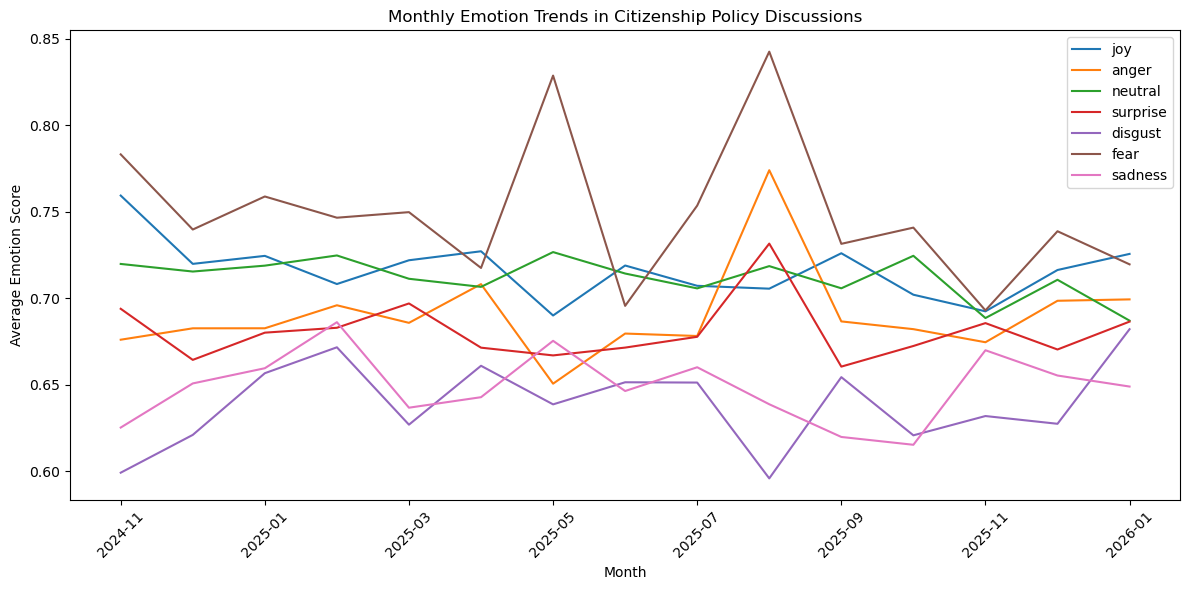

In [53]:
monthly_emotions.plot(figsize=(12,6))
plt.title("Monthly Emotion Trends in Citizenship Policy Discussions")
plt.xlabel("Month")
plt.ylabel("Average Emotion Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## *4.6. POLARIZATION ANALYSIS*

#### Polarization ≠ sentiment.
#### It’s about extremes, conflict, us vs them language.

### Toxic / polarizing language model

In [55]:
toxicity_classifier = pipeline(
    "text-classification",
    model="unitary/toxic-bert",
    truncation=True
)

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

C:\Users\Hp\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Hp\.cache\huggingface\hub\models--unitary--toxic-bert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: unitary/toxic-bert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

#### Apply

In [56]:
def get_toxicity(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0
    result = toxicity_classifier(text[:512])[0]
    return result['score'] if result['label'] == 'toxic' else 0

df['toxicity'] = df['clean_comment'].apply(get_toxicity)

#### Monthly

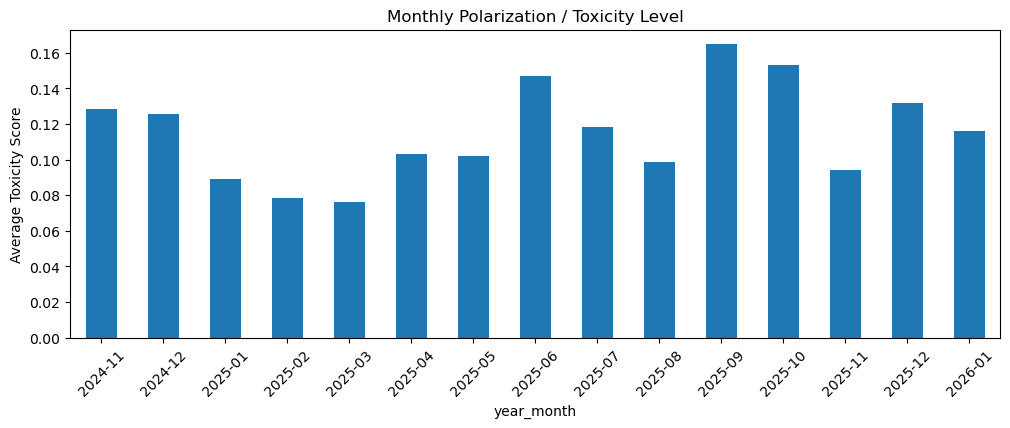

In [57]:
monthly_toxicity = df.groupby('year_month')['toxicity'].mean()
monthly_toxicity.plot(kind='bar', figsize=(12,4))
plt.title("Monthly Polarization / Toxicity Level")
plt.ylabel("Average Toxicity Score")
plt.xticks(rotation=45)
plt.show()

## **5. Media outlet comparison**

## *5.1. sanity check of Media Outlet column*

In [58]:
df['media_outlet'].value_counts()

media_outlet
CNN                            7835
MS NOW                         6597
Democracy Now                  6197
Valuetainment                  5804
LiveNOW from FOX               4662
KMPH FOX 26 NEWS               3757
NBC NEWS                       3311
The Wall Street Journal        2876
Washington Post Universe       2816
ABC NEWS                       2317
Darian Immigration Law         2088
Forbes Breaking News           1291
CBS NEWS                        954
New York Times                  859
CBS EVENING NEWS & CBS NEWS     800
First Post                      777
Top 10 Tales                    545
Name: count, dtype: int64

## *5.2. Volume of discussion per outlet (baseline)*

#### This answers:

Which outlets generate more discussion on citizenship policies?

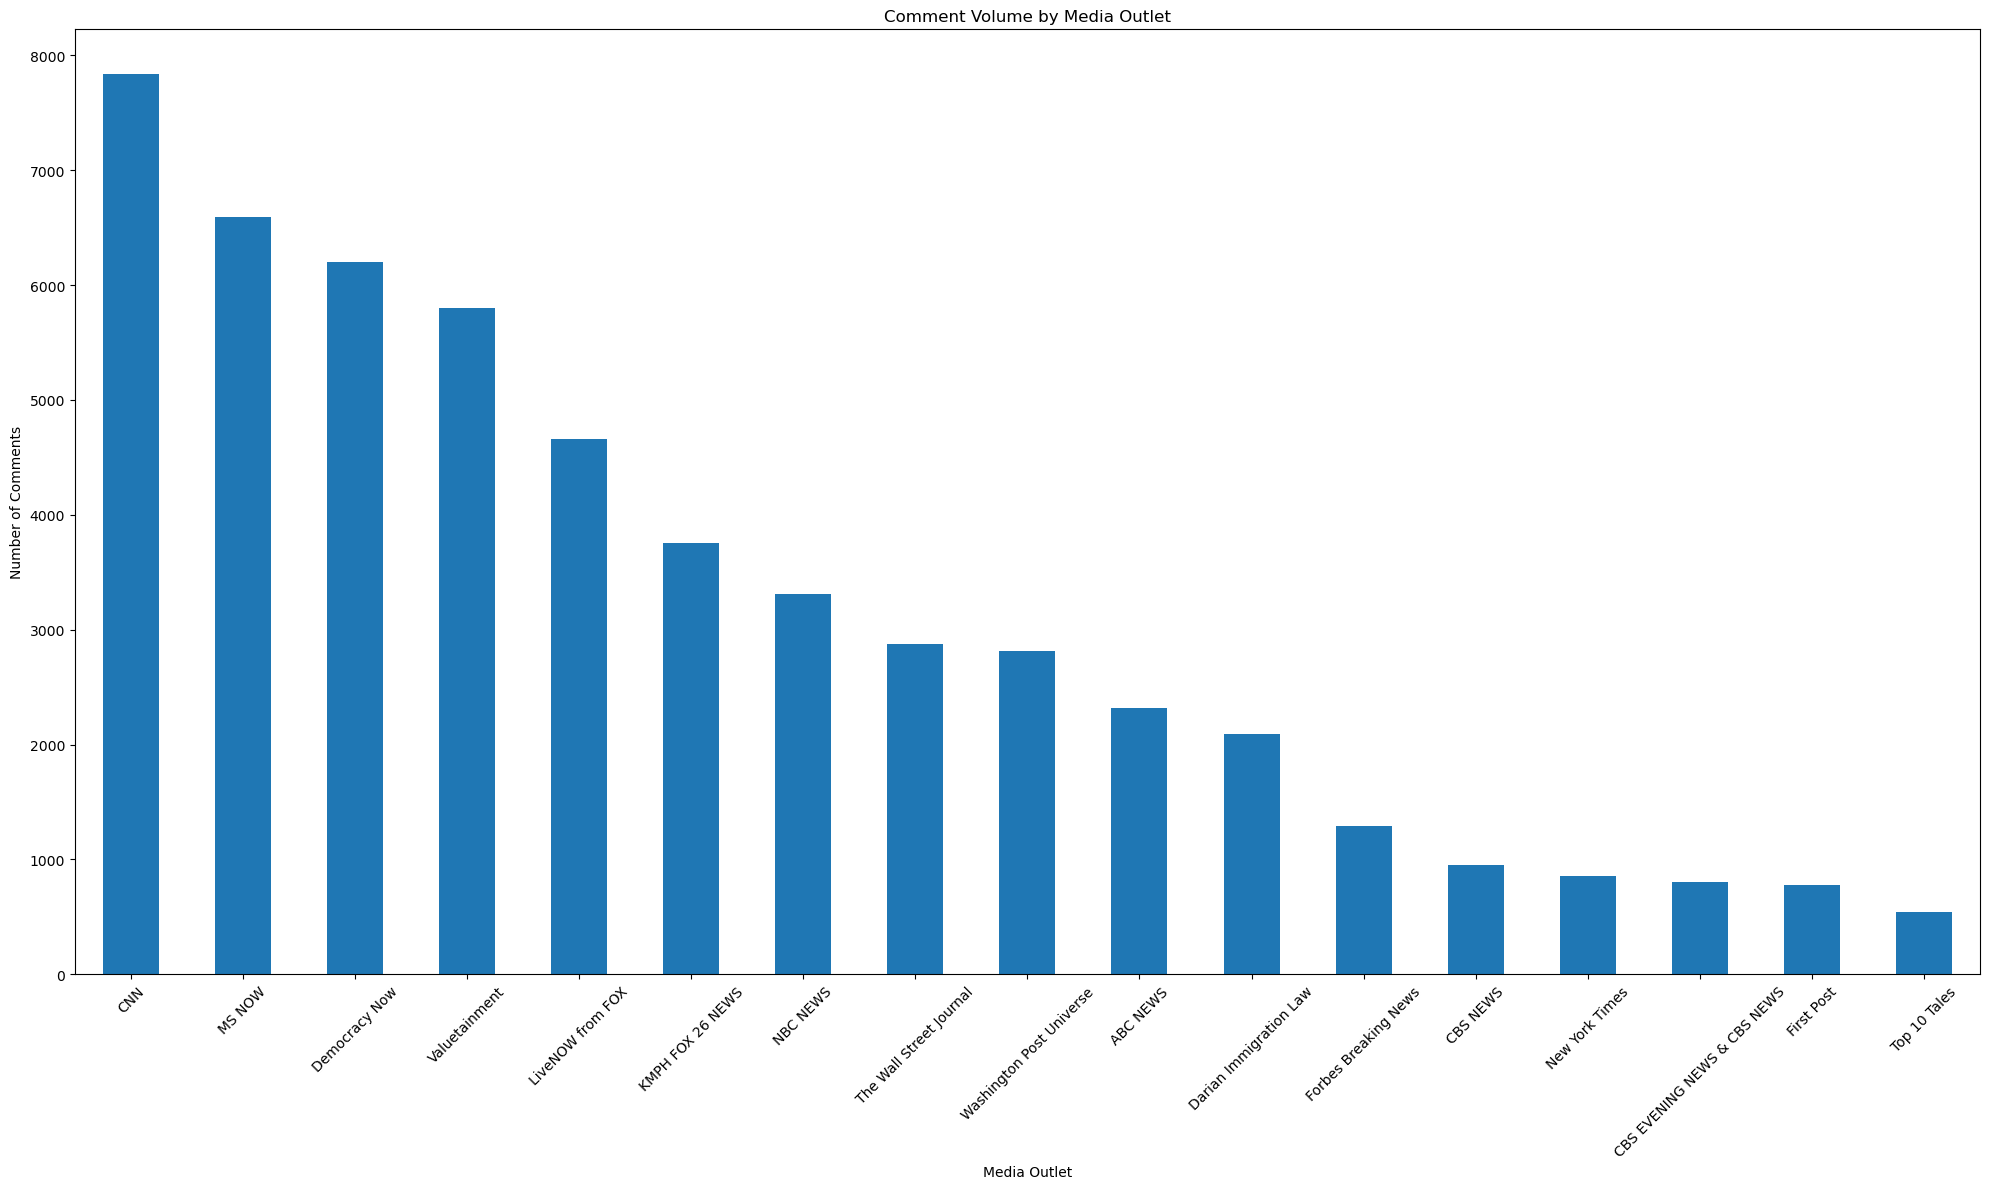

In [83]:
outlet_volume = df['media_outlet'].value_counts()

outlet_volume.plot(kind='bar', figsize=(20,12))
plt.title("Comment Volume by Media Outlet")
plt.ylabel("Number of Comments")
plt.xlabel("Media Outlet")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Why this matters
Volume differences explain why some outlets appear more emotional or polarized later.

## *5.3. Sentiment comparison by media outlet*

#### Assuming you already have a sentiment column (polarity score)

#### Map sentiment labels to numbers first

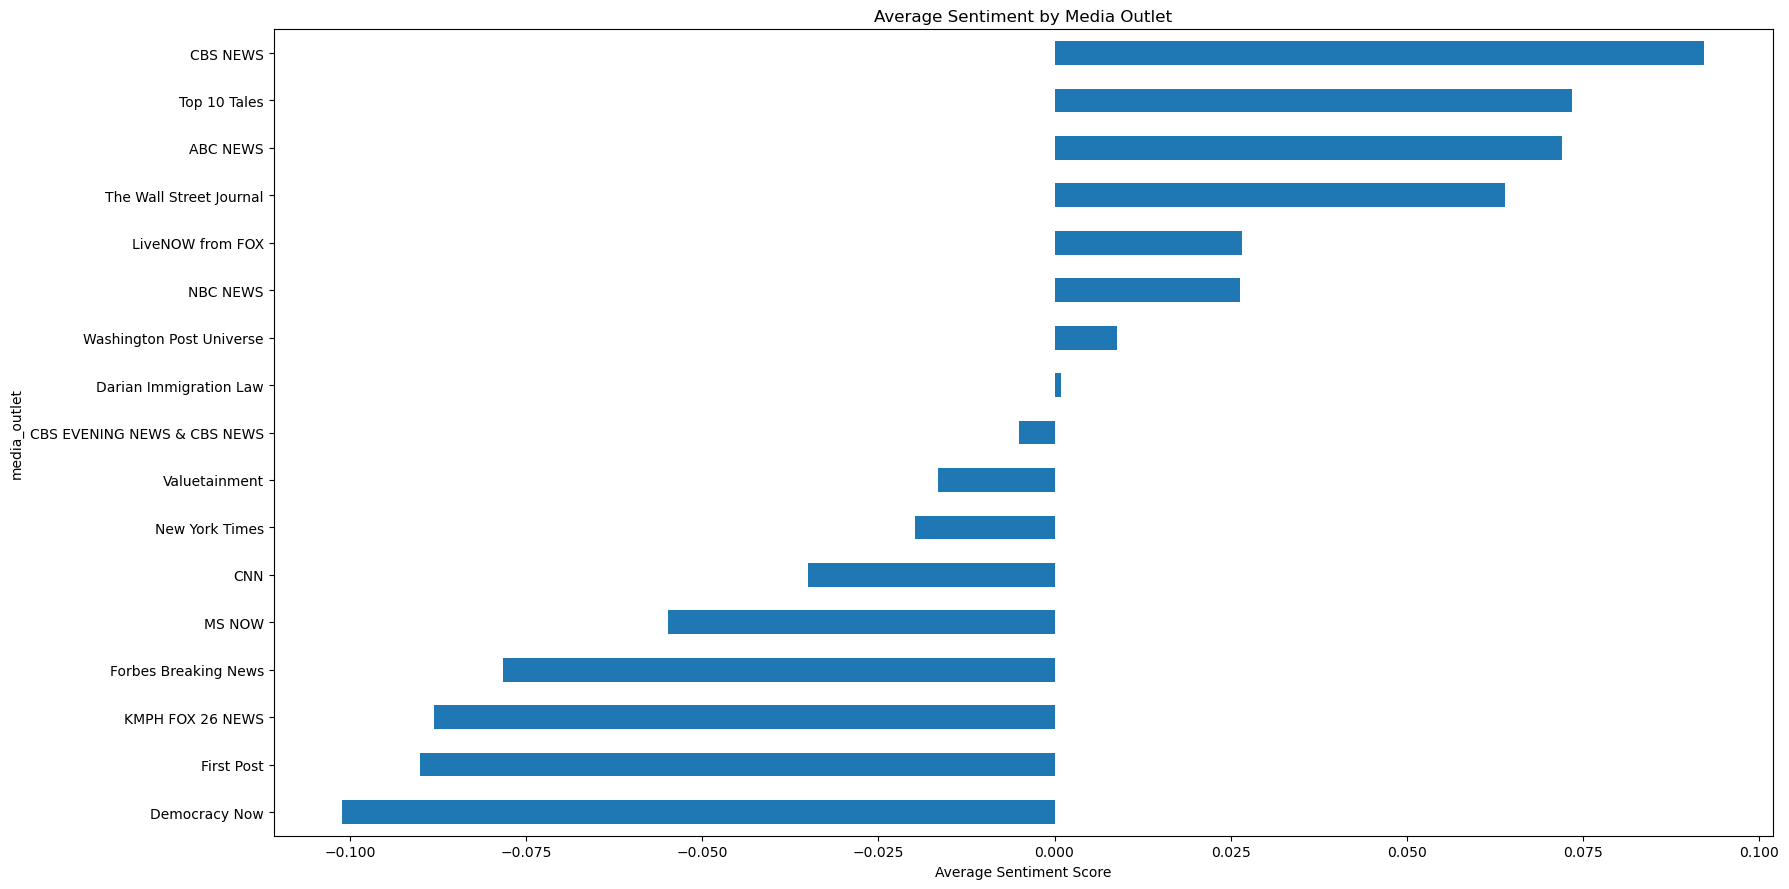

In [84]:
outlet_sentiment = (
    df.groupby('media_outlet')['sentiment_score']
      .mean()
      .sort_values()
)

outlet_sentiment.plot(kind='barh', figsize=(18, 9))
plt.title("Average Sentiment by Media Outlet")
plt.xlabel("Average Sentiment Score")
plt.tight_layout()
plt.show()


## *5.4. Emotion comparison (this is the key part)*

#### We’ll compare average emotion levels per outlet

### *Step A — Select emotion columns*

In [72]:
emotion_cols = [col for col in df.columns 
                if col in ['anger', 'fear', 'joy', 'sadness', 'neutral']]

### *Step B — Group by outlet*

In [74]:
outlet_emotions = df.groupby('media_outlet')[emotion_cols].mean()
outlet_emotions

,joy,anger,neutral,fear,sadness
media_outlet,,,,,
ABC NEWS,0.729999,0.677642,0.734124,0.717029,0.654579
CBS EVENING NEWS & CBS NEWS,0.698275,0.670741,0.681305,0.694148,0.661152
CBS NEWS,0.658532,0.674577,0.714702,0.662750,0.666409
CNN,0.698001,0.686187,0.711145,0.729501,0.630942
Darian Immigration Law,0.730945,0.674366,0.705985,0.751255,0.661471
Democracy Now,0.718915,0.706679,0.696611,0.743025,0.671302
First Post,0.714141,0.690366,0.707897,0.808694,0.656127
Forbes Breaking News,0.751403,0.698292,0.673526,0.677304,0.607575
KMPH FOX 26 NEWS,0.696788,0.701263,0.701112,0.716929,0.653996


### *Step C — Plot*

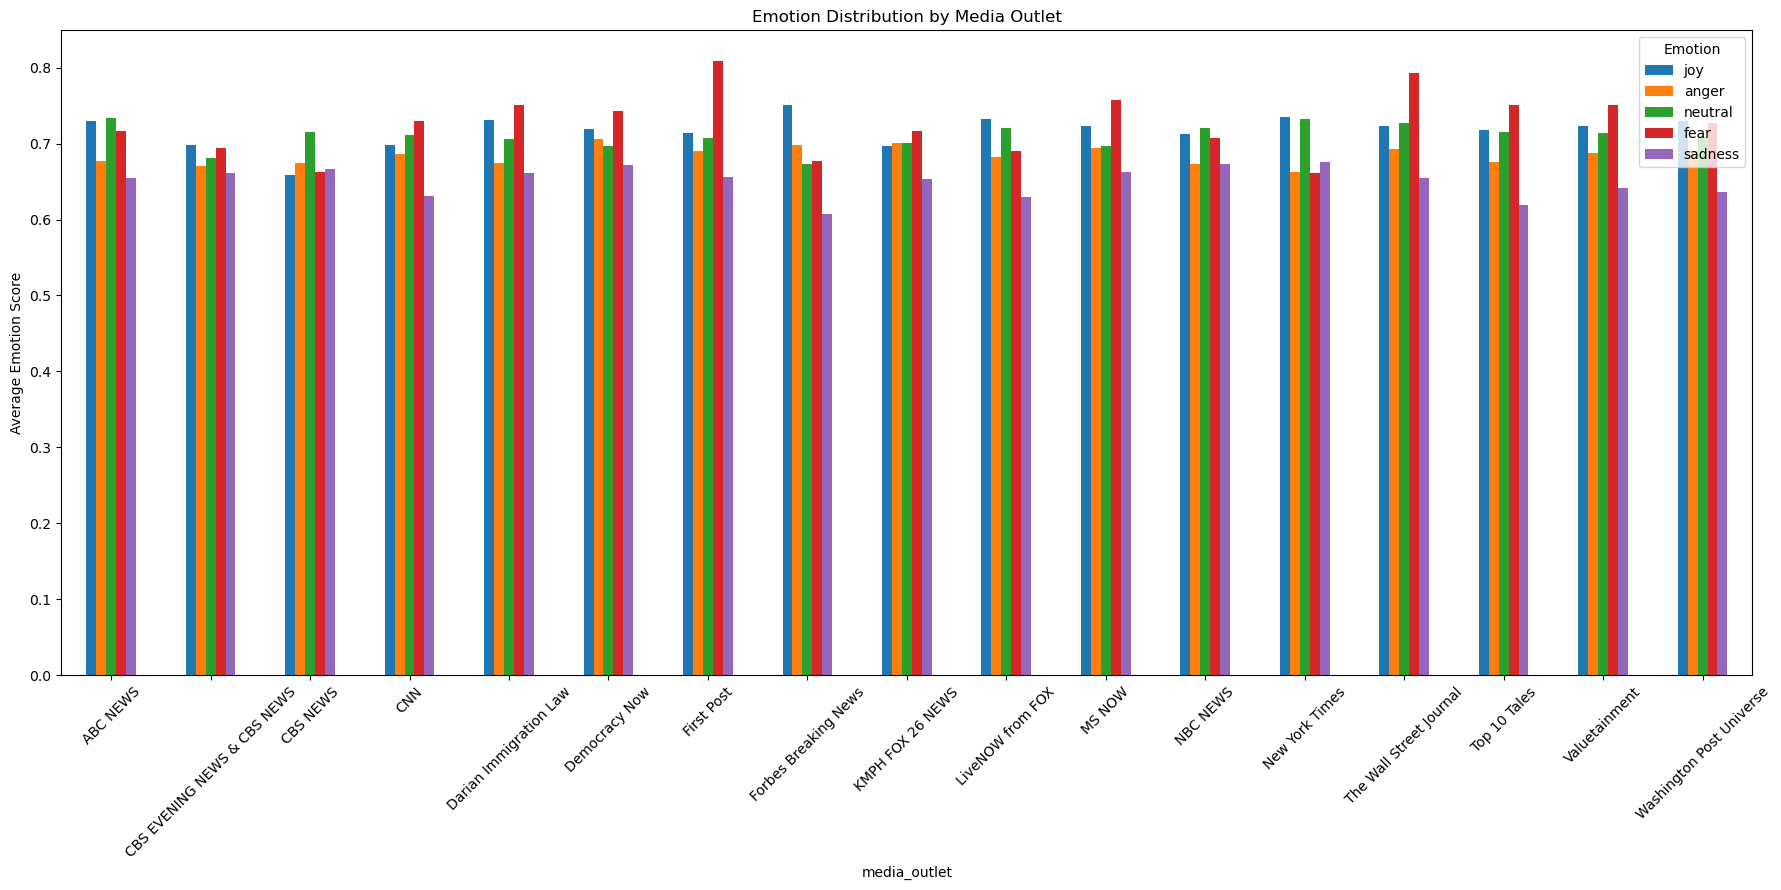

In [85]:
outlet_emotions.plot(kind='bar', figsize=(18,9))
plt.title("Emotion Distribution by Media Outlet")
plt.ylabel("Average Emotion Score")
plt.xticks(rotation=45)
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

## *5.5. Polarization / toxicity by outlet (very important)*

#### This directly supports polarization claim

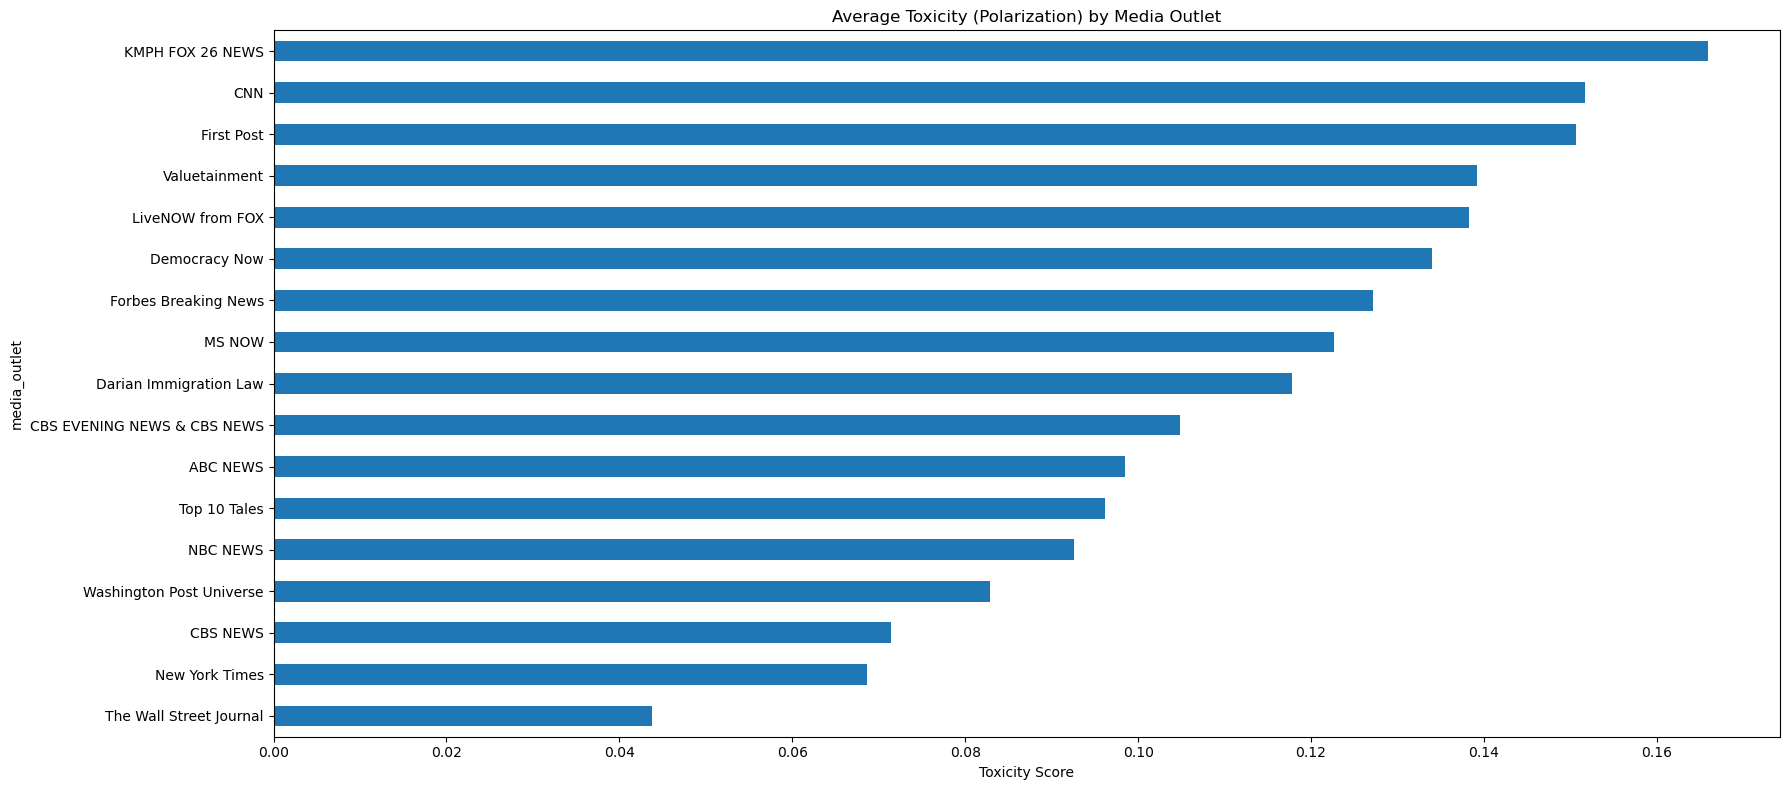

In [86]:
outlet_toxicity = df.groupby('media_outlet')['toxicity'].mean().sort_values()

outlet_toxicity.plot(kind='barh', figsize=(18,8))
plt.title("Average Toxicity (Polarization) by Media Outlet")
plt.xlabel("Toxicity Score")
plt.tight_layout()
plt.show()

## *5.6. Monthly comparison within each outlet (advanced but powerful)*

#### This shows how outlets differ over time.

In [79]:
outlet_monthly_toxicity = (
    df.groupby(['media_outlet', 'year_month'])['toxicity']
      .mean()
      .reset_index()
)

#### Plot for top 5 outlets only

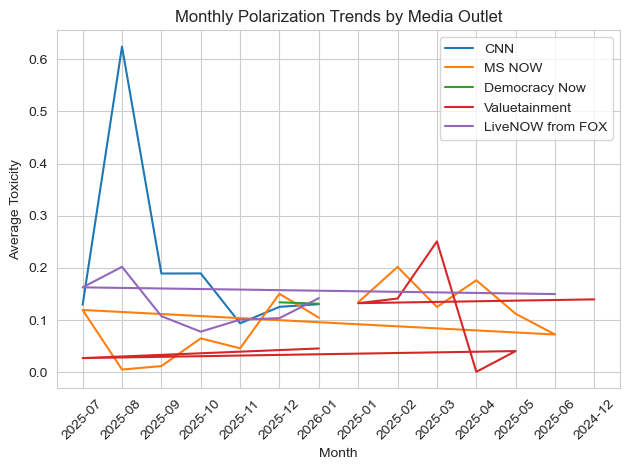

In [104]:
top_outlets = df['media_outlet'].value_counts().head(5).index

for outlet in top_outlets:
    subset = outlet_monthly_toxicity[outlet_monthly_toxicity['media_outlet'] == outlet]
    plt.plot(subset['year_month'], subset['toxicity'], label=outlet)

plt.title("Monthly Polarization Trends by Media Outlet")
plt.xlabel("Month")
plt.ylabel("Average Toxicity")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## This is the end for now!!!